In [1]:
import gym
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #### REMOVE THIS LINE WHEN CUDA CONFIG IS FIXED
import tensorflow as tf
import numpy as np
import sys
import time
import gym_snake
import json
import importlib
import random
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.insert(0, '..')
os.chdir('..')
from utils.Buffer import ReplayBuffer
from utils.Conv import ConvHead
from rl.models import get_policy_architecture, get_value_architecture, get_vision_architecture
from algos.PPO import PPO_agent
from algos.DQN import DQN_agent
from utils.Loader import load_agent
from utils.utils import *

# %load_ext line_profiler
# %matplotlib notebook

In [2]:
runs = 5
epochs = 100
env = 'lunarlander'
base_name = 'lunarlander-DQN-eps_anneal_compare2'

In [3]:
cb = [
    {
        "type": "InitBufferCallback",
        "kwargs": {
            "episodes": 50
        }
    },
    {
        "type": "AnnealingSchedulerCallback",
        "kwargs": {
            "target": "epsilon",
            "schedule": [
                {
                    "type": "Schedule",
                    "kwargs": {
                        "length": 200,
                        "start_val": 0.4,
                        "end_val": 0.01,
                        "fn": "linear"
                    }
                }
            ]
        }
    }
]

In [ ]:
hist1, hist2 = compare_algos(base_name, runs, epochs, env, 
    # dict({'algo': ['DDQN', 'PER', 'Dueling']})
    dict({'callbacks': cb})
)

Run 1a:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 1b:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2a:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2b:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3a:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3b:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 4a:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run 4b:


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plot_runs(hist1, hist2)

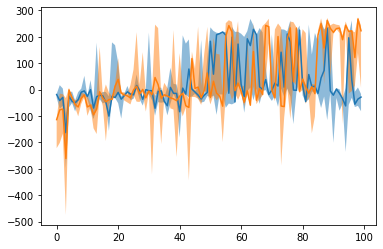

In [16]:
plot_runs(hist1, hist2) # blue is hist1, orange is hist2

In [4]:
# tetris = importlib.import_module('pytris-effect.src.gameui')

In [5]:
run_name = 'snake'
action = 'train'
algo = ('DDQN', 'Dueling')

In [6]:
cfg_fp = os.path.join('..', 'configs', run_name + '.json')
with open(cfg_fp, 'r') as f:
    config = json.load(f)
ckpt_folder = os.path.join('..', 'checkpoints')

In [7]:
env_name = config['env']
if run_name == 'tetris':
    env = tetris.GameUI(graphic_mode=False, its_per_sec=2, sec_per_tick=0.5)
else:
    env = gym.make(env_name).env if 'use_raw_env' in config else gym.make(env_name)

In [8]:
env.reset().shape

(150, 150, 3)

In [9]:
def show_img(arr):
    scaling = 30
    data = np.zeros((scaling*arr.shape[0], scaling*arr.shape[1], 3), dtype=np.uint8)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                data[i,j,k] = arr[i//scaling,j//scaling,k]
    img = Image.fromarray(data, 'RGB')
    # img.save('my.png')
    img.show()

In [10]:
if action == 'evaluate':
    %lprun -f env.drawMatrix env.drawMatrix()

In [11]:
if action == 'evaluate':
    arr = env.reset()[::10,::10,:]
    img = Image.fromarray(arr, 'RGB')
    img.show()
    #show_img(env.reset())

In [12]:
if False:
    action = 1
    obs, reward, dn, info = env.step(action)
    show_img(obs)
    print(reward, dn, info)

In [13]:
def do_step():
    _, _, dn, _ = env.step(random.choice(range(7)))
    if dn:
        env.reset()

In [14]:
#%timeit env.reset()

In [15]:
#%timeit do_step()

In [16]:
#%lprun -f env.get_obs do_step()

In [17]:
model = get_policy_architecture(env_name, algo=algo)
if 'DQN' in "\n".join(algo):
    target = tf.keras.models.clone_model(model)
else:
    value = get_value_architecture(env_name)

In [18]:
if 'DQN' in "\n".join(algo):
    agent = DQN_agent(
        model,
        # (TODO): Move args for ReplayBuffer into DQN
        ReplayBuffer(config.get("max_buf_size", 20000), mode='uniform'),
        target=target,
        env=env,
        mode=('DDQN'), # 'PER'
        learning_rate=config['learning_rate'],
        batch_size=config['batch_size'],
        update_steps=1,
        update_freq=4,
        multistep=5,
        alpha=1.5,
        beta=1.0,
        gamma=0.95,
        target_delay=1000,
        delta=1.0,
        # delta=0.000003,
        env_name=config['env_name'],
        algo_name='DQN',
        ckpt_folder=ckpt_folder,
        run_name='snake-DQN-pretrain-hard_update-uniform-multistep5-7'
    )
elif 'PPO' in "\n".join(algo):
    agent = PPO_agent(
        model,
        value,
        env=env,
        learning_rate=config['learning_rate'],
        minibatch_size=config['minibatch_size'],
        gamma=0.99,
        env_name=config['env_name'],
        run_name='snake-PPO-pretrain',
        ckpt_folder=ckpt_folder
    )

In [19]:
t_max = config['t_max']

In [20]:
p_buf = []

def collect_rollout(env, t_max, policy):
    s = agent.preprocess(env.reset())
    for t in range(t_max):
        act = policy(s)
        ss, r, dn, _ = env.step(agent.action_wrapper(act))
        ss = agent.preprocess(ss)
        p_buf.append([s, ss])
        s = ss
        if dn:
            break

In [21]:
pretrain = True
if pretrain and action == 'train': # only necessary for tasks on raw pixels (vision)
    model = get_vision_architecture(env_name)
    out = tf.keras.layers.Dense(16, activation=None)(model.output)
    embed = tf.keras.Model(inputs=model.input, outputs=out)
    # get some data from random interactions with the env
    for i in tqdm(range(500)):
        collect_rollout(env, t_max, lambda x: np.random.choice(4))
    print("Collected {} samples".format(len(p_buf)))
    head = ConvHead(embed, p_buf)
    head.train(6)
    
    out = head.model.layers[-2].output
    vision = tf.keras.Model(inputs=head.model.input, outputs=out)
    pretrained_model = get_policy_architecture(env_name, algo=algo, head=vision)
    agent.set_model(pretrained_model)

100%|██████████| 500/500 [00:01<00:00, 457.76it/s]


Collected 15340 samples


  0%|          | 0/239 [00:00<?, ?it/s]

[0] Loss: [0.16207144 0.16422944 0.17887095 0.17409125 0.19734879 0.21781886
 0.23387843 0.22500688 0.23673627 0.1937929  0.24326453 0.25857937
 0.17051055 0.20156612 0.21865784 0.21861552 0.18118884 0.19640914
 0.2025929  0.22165535 0.20173624 0.20688468 0.21547227 0.17386135
 0.21331543 0.21538275 0.24038132 0.23202287 0.1916675  0.19486418
 0.15530969 0.13813093 0.20592816 0.21268854 0.17688681 0.16875999
 0.18357621 0.17544466 0.18546654 0.1651627  0.27501094 0.2845768
 0.27642527 0.29021144 0.17672037 0.17219049 0.21144046 0.18698743
 0.17732346 0.18187226 0.26007393 0.28570256 0.20874463 0.19590168
 0.2097269  0.20679654 0.17465702 0.17358631 0.22824326 0.24328586
 0.28171524 0.24776584 0.24015933 0.2051436  0.27498612 0.33187854
 0.15795347 0.17067455 0.21202    0.21311164 0.23877276 0.23929784
 0.16703236 0.14166465 0.17781574 0.16438174 0.15650536 0.18442966
 0.24041952 0.2079033  0.2299893  0.23280607 0.20981313 0.22526228
 0.24233896 0.20656031 0.23173124 0.22923258 0.270834

  0%|          | 0/239 [00:00<?, ?it/s]

[1] Loss: [0.06608044 0.07096907 0.0868551  0.06263551 0.04648707 0.04968729
 0.04721485 0.03682361 0.03976986 0.03505346 0.05929387 0.06991001
 0.05749486 0.05228494 0.04985422 0.04354837 0.04065986 0.04368109
 0.03940775 0.03472828 0.03732676 0.04097142 0.04393915 0.03408255
 0.03781205 0.04436415 0.02870641 0.02737951 0.03803553 0.04434922
 0.04586969 0.03829176 0.06061662 0.04370287 0.04050909 0.03675894
 0.04232659 0.04525478 0.07392286 0.07023486 0.05406747 0.05565314
 0.04819098 0.04888806 0.04207579 0.04111275 0.05111394 0.04756966
 0.06411922 0.04901112 0.06108206 0.0499912  0.03603443 0.03855403
 0.06306186 0.06362385 0.05657302 0.05354837 0.05325956 0.0515463
 0.05331401 0.04907485 0.07831968 0.09182312 0.04262915 0.03161718
 0.04138502 0.0437209  0.06222383 0.06522892 0.04171403 0.04547331
 0.05722599 0.06518463 0.04003819 0.03790011 0.06562233 0.05431224
 0.0596202  0.05330799 0.06059129 0.05579082 0.04254686 0.03628898
 0.04860356 0.04298042 0.05865681 0.04513944 0.038353

  0%|          | 0/239 [00:00<?, ?it/s]

[2] Loss: [0.03651669 0.04229024 0.05569711 0.05452789 0.03677306 0.03046176
 0.05449818 0.06663302 0.04291207 0.03697745 0.0641152  0.05121865
 0.04275385 0.04533607 0.03816033 0.03768339 0.04733712 0.04448603
 0.04699548 0.05901052 0.04663393 0.01956399 0.03435628 0.03192681
 0.03838997 0.05149022 0.04673856 0.03772877 0.04097513 0.05036984
 0.04807089 0.03889022 0.02323935 0.02445655 0.05227857 0.05944159
 0.04191131 0.04997728 0.05360296 0.05451753 0.03659081 0.03415033
 0.0493088  0.05013776 0.03447326 0.04404224 0.0602532  0.06551577
 0.06974792 0.05170915 0.06444231 0.04678233 0.05620944 0.07084816
 0.03593076 0.04066257 0.06110825 0.05054953 0.02757229 0.01887234
 0.06325857 0.06284911 0.02683798 0.03467828 0.03105195 0.03475263
 0.04164911 0.03778234 0.05091904 0.04359056 0.05845844 0.04506823
 0.03020418 0.04177947 0.0293866  0.04341442 0.04346883 0.04675227
 0.03172495 0.04121622 0.05378237 0.04296017 0.04023663 0.04158319
 0.04032715 0.03795957 0.03152762 0.04175606 0.07341

  0%|          | 0/239 [00:00<?, ?it/s]

[3] Loss: [0.03845309 0.04579066 0.05518716 0.05361039 0.03579831 0.02469344
 0.01971919 0.02784969 0.02648689 0.03380919 0.0244562  0.02571085
 0.03444288 0.03517738 0.04794062 0.06162735 0.01590949 0.02209456
 0.05152367 0.0386446  0.04308474 0.03793183 0.04706028 0.03035263
 0.0409775  0.05237413 0.03104175 0.04130465 0.02741797 0.0314894
 0.06332452 0.05259414 0.04055731 0.05016332 0.04082781 0.03484916
 0.02067821 0.02527783 0.02727887 0.02916835 0.06522166 0.04931908
 0.05360284 0.04298502 0.01890577 0.02068627 0.03861409 0.03070395
 0.02973093 0.04151338 0.0340594  0.04210494 0.02859811 0.02952087
 0.03721852 0.04967336 0.06754504 0.03998899 0.04377296 0.05087035
 0.03574838 0.03907729 0.03842021 0.04523966 0.05148607 0.03412048
 0.04267645 0.02766808 0.02516358 0.0329487  0.03992095 0.04851993
 0.05080765 0.04540567 0.06495339 0.07095345 0.04011546 0.03157413
 0.04927352 0.04822543 0.04200134 0.03076501 0.04469045 0.05348495
 0.04237165 0.03880769 0.04736083 0.05602064 0.027296

  0%|          | 0/239 [00:00<?, ?it/s]

[4] Loss: [0.07432232 0.04493627 0.04294223 0.04096032 0.03906918 0.05358807
 0.03667955 0.03302206 0.04028605 0.03529242 0.04998352 0.05795919
 0.05518873 0.05120972 0.0525756  0.04548169 0.03581625 0.03640327
 0.03020453 0.0397019  0.04524422 0.020797   0.03283569 0.03527138
 0.04068377 0.02317345 0.02977543 0.03561272 0.03218897 0.0342539
 0.02013012 0.02912482 0.03491794 0.03500136 0.05594141 0.05024605
 0.04663849 0.05703757 0.04874103 0.04875229 0.0503183  0.0423066
 0.04426927 0.04531255 0.03774369 0.02892774 0.03318269 0.02866987
 0.03315325 0.02994227 0.03539295 0.04820392 0.05243016 0.03742301
 0.05655768 0.0722189  0.0211629  0.01800555 0.04090874 0.03662692
 0.04305533 0.04159042 0.03205605 0.04015957 0.05638218 0.06665453
 0.04358838 0.04146018 0.05579618 0.05330103 0.04072233 0.03358936
 0.05197082 0.04254153 0.03696806 0.03605074 0.03581255 0.0426849
 0.04062825 0.04444099 0.0418625  0.02843546 0.03404472 0.02711272
 0.05813572 0.04098496 0.04770242 0.03558632 0.06245985

  0%|          | 0/239 [00:00<?, ?it/s]

[5] Loss: [0.04530404 0.06506164 0.02913353 0.03491594 0.05039276 0.05554381
 0.03593262 0.04023889 0.05723673 0.05027205 0.04109735 0.03817065
 0.0298716  0.03176341 0.04523849 0.03366725 0.03512605 0.04500847
 0.02953389 0.04669889 0.04236947 0.05278236 0.06045643 0.03392676
 0.04538282 0.03654708 0.02728711 0.02864299 0.03663272 0.03013776
 0.0242861  0.02630979 0.03278621 0.02076043 0.04418003 0.03399241
 0.02503235 0.03080395 0.06749966 0.07030056 0.03570505 0.04772815
 0.05695973 0.05585954 0.03430215 0.04935735 0.03622068 0.03977071
 0.05536965 0.03950199 0.06537244 0.04659582 0.0355219  0.02867193
 0.02926116 0.0245997  0.03663009 0.03199714 0.05411894 0.05270815
 0.07208761 0.07046887 0.04352183 0.04116809 0.04003951 0.03262783
 0.02278956 0.036877   0.04348972 0.04031864 0.02613353 0.03116534
 0.05848362 0.04721993 0.03004063 0.03663519 0.03499538 0.03794961
 0.04152729 0.05391518 0.04455994 0.04360804 0.04890003 0.0486824
 0.01865504 0.02369533 0.02997198 0.02785135 0.030314

TypeError: get_policy_architecture() got an unexpected keyword argument 'pretrain'

In [22]:
pretrained_model = get_policy_architecture(env_name, algo=algo, head=vision)
agent.set_model(pretrained_model)

In [23]:
agent.load_from_checkpoint()
hist = []

In [24]:
if action == 'train':
    if 'DQN' in "\n".join(algo):
        # fill buffer with some random samples
        for i in tqdm(range(500)):
            agent.collect_rollout(t_max=t_max, policy=lambda x: np.random.choice(4), train=False, display=False)
        #print(agent.epsilon)
        #agent.epsilon = 0.05
        hist += agent.train(epochs=config['train_epochs'], t_max=t_max, display=False)
    elif 'PPO' in "\n".join(algo):
        agent.train(epochs=config['train_epochs'], t_max=t_max, buf_size=3000, min_buf_size=600, display=False)

100%|██████████| 500/500 [00:01<00:00, 469.00it/s]


Training epochs:   0%|          | 0/20000 [00:00<?, ?it/s]

[5] Average reward: -1.0
Predicted reward: [[-0.04494638 -0.06519236 -0.06496485 -0.09102722]]
Buffer size: 14711
Saving to checkpoint...
[10] Average reward: -0.8
Predicted reward: [[-0.0541863  -0.14556536 -0.15801829 -0.136219  ]]
Buffer size: 14784
Saving to checkpoint...
[15] Average reward: -1.0
Predicted reward: [[-0.21347167 -0.13125837 -0.06782893 -0.00234007]]
Buffer size: 14910
Saving to checkpoint...
[20] Average reward: -0.8
Predicted reward: [[ 0.04583263  0.02079096  0.09753878 -0.06431076]]
Buffer size: 15035
Saving to checkpoint...
[25] Average reward: -0.8
Predicted reward: [[0.02698723 0.07697456 0.06024702 0.012311  ]]
Buffer size: 15109
Saving to checkpoint...
[30] Average reward: -1.0
Predicted reward: [[-0.08768529 -0.06441404  0.01772811  0.02166178]]
Buffer size: 15200
Saving to checkpoint...
[35] Average reward: -0.8
Predicted reward: [[ 0.01833391 -0.02038789 -0.03147763 -0.02695323]]
Buffer size: 15564
Saving to checkpoint...
[40] Average reward: -0.8
Predic

[300] Average reward: 0.2
Predicted reward: [[-0.16349328 -0.14795628  0.00278419 -0.16755034]]
Buffer size: 34033
Saving to checkpoint...
[305] Average reward: -0.4
Predicted reward: [[-0.13659158 -0.1579846  -0.23719743 -0.07533932]]
Buffer size: 34226
Saving to checkpoint...
[310] Average reward: 0.0
Predicted reward: [[-0.05133471  0.17707607  0.1460712   0.16672105]]
Buffer size: 34428
Saving to checkpoint...
[315] Average reward: -0.8
Predicted reward: [[-0.10838002 -0.15866014 -0.00441885 -0.2053265 ]]
Buffer size: 34643
Saving to checkpoint...
[320] Average reward: -0.8
Predicted reward: [[-0.13665813  0.03908518 -0.14367911 -0.04582806]]
Buffer size: 35112
Saving to checkpoint...
[325] Average reward: -0.6
Predicted reward: [[0.2846845  0.04725912 0.00233987 0.2721127 ]]
Buffer size: 35326
Saving to checkpoint...
[330] Average reward: -0.8
Predicted reward: [[0.07560807 0.48034525 0.00228536 0.8942871 ]]
Buffer size: 35487
Saving to checkpoint...
[335] Average reward: -0.2
Pre

[595] Average reward: -0.4
Predicted reward: [[-0.1877444  -0.3404611  -0.17131065 -0.28531694]]
Buffer size: 40000
Saving to checkpoint...
[600] Average reward: -1.0
Predicted reward: [[-0.13945541 -0.13061373  0.03205381  0.0178372 ]]
Buffer size: 40000
Saving to checkpoint...
[605] Average reward: -0.4
Predicted reward: [[-0.24801257 -0.22433776 -0.35440487 -0.2188476 ]]
Buffer size: 40000
Saving to checkpoint...
[610] Average reward: -0.4
Predicted reward: [[ 0.22882436 -0.12929282 -0.00069581 -0.07024249]]
Buffer size: 40000
Saving to checkpoint...
[615] Average reward: -0.6
Predicted reward: [[-0.13797927 -0.14066583  0.00166442 -0.06549275]]
Buffer size: 40000
Saving to checkpoint...
[620] Average reward: -0.2
Predicted reward: [[ 0.03258009 -0.17637053  0.10304354 -0.05571795]]
Buffer size: 40000
Saving to checkpoint...
[625] Average reward: -0.8
Predicted reward: [[ 0.21545622 -0.13516757  0.27121067 -0.03812772]]
Buffer size: 40000
Saving to checkpoint...
[630] Average reward

[895] Average reward: -0.2
Predicted reward: [[0.33335036 0.54315954 0.33009136 0.16896763]]
Buffer size: 40000
Saving to checkpoint...
[900] Average reward: -0.8
Predicted reward: [[-0.00422525 -0.42951655  0.32762277 -0.37258923]]
Buffer size: 40000
Saving to checkpoint...
[905] Average reward: -0.8
Predicted reward: [[-0.16169283  0.0072808   0.1264753  -0.07446837]]
Buffer size: 40000
Saving to checkpoint...
[910] Average reward: -0.8
Predicted reward: [[0.3739469  0.01880586 0.03942977 0.12047781]]
Buffer size: 40000
Saving to checkpoint...
[915] Average reward: -1.0
Predicted reward: [[0.51774573 0.48737627 0.31207842 0.3650329 ]]
Buffer size: 40000
Saving to checkpoint...
[920] Average reward: -0.8
Predicted reward: [[0.21625394 0.63911885 0.5270331  0.39609617]]
Buffer size: 40000
Saving to checkpoint...
[925] Average reward: -0.4
Predicted reward: [[-0.01433378 -0.13035315  0.07935786  0.03206688]]
Buffer size: 40000
Saving to checkpoint...
[930] Average reward: -0.4
Predicted

[1190] Average reward: -0.2
Predicted reward: [[ 0.21571755  0.21720469  0.24001682 -0.24147964]]
Buffer size: 40000
Saving to checkpoint...
[1195] Average reward: -0.4
Predicted reward: [[ 0.35878694  0.08363855 -0.05595875  0.01156569]]
Buffer size: 40000
Saving to checkpoint...
[1200] Average reward: -0.8
Predicted reward: [[-0.17987084  0.21097708 -0.14300323  0.09006715]]
Buffer size: 40000
Saving to checkpoint...
[1205] Average reward: -0.8
Predicted reward: [[-0.5853226  -0.47566938 -0.34616137 -0.2879696 ]]
Buffer size: 40000
Saving to checkpoint...
[1210] Average reward: -0.8
Predicted reward: [[ 0.5970007  -0.01927435  0.11520159  0.4923309 ]]
Buffer size: 40000
Saving to checkpoint...
[1215] Average reward: -0.8
Predicted reward: [[0.31364405 0.09572566 0.72820354 0.0577786 ]]
Buffer size: 40000
Saving to checkpoint...
[1220] Average reward: -1.0
Predicted reward: [[ 0.14789104 -0.03033829  0.22079468  0.17118418]]
Buffer size: 40000
Saving to checkpoint...
[1225] Average re

[1485] Average reward: -0.6
Predicted reward: [[-0.03915071 -0.06798697  0.1959418   0.11998296]]
Buffer size: 40000
Saving to checkpoint...
[1490] Average reward: -0.8
Predicted reward: [[-0.341954   -0.13687181  0.48449135  0.31171823]]
Buffer size: 40000
Saving to checkpoint...
[1495] Average reward: -0.6
Predicted reward: [[ 0.38058376  0.09914088 -0.1553073   0.1155951 ]]
Buffer size: 40000
Saving to checkpoint...
[1500] Average reward: -0.6
Predicted reward: [[ 0.47260487  0.24258816 -0.15006399  0.37645018]]
Buffer size: 40000
Saving to checkpoint...
[1505] Average reward: -1.0
Predicted reward: [[ 0.234514   -0.060395   -0.07217336  0.16119146]]
Buffer size: 40000
Saving to checkpoint...
[1510] Average reward: -0.8
Predicted reward: [[-0.49888945 -0.19767332  0.09531355  0.10003901]]
Buffer size: 40000
Saving to checkpoint...
[1515] Average reward: -0.6
Predicted reward: [[0.17746496 0.41051495 0.26233172 0.3273481 ]]
Buffer size: 40000
Saving to checkpoint...
[1520] Average re

[1780] Average reward: 0.0
Predicted reward: [[ 0.2180748  -0.11273956  0.36594677  0.3878293 ]]
Buffer size: 40000
Saving to checkpoint...
[1785] Average reward: -0.6
Predicted reward: [[ 0.07404375 -0.0623486   0.11791885  0.03856492]]
Buffer size: 40000
Saving to checkpoint...
[1790] Average reward: -1.0
Predicted reward: [[ 0.22203636  0.15024495 -0.01729774  0.123559  ]]
Buffer size: 40000
Saving to checkpoint...
[1795] Average reward: -0.4
Predicted reward: [[ 0.13365364 -0.0878284   0.14808464  0.11912537]]
Buffer size: 40000
Saving to checkpoint...
[1800] Average reward: -0.6
Predicted reward: [[-0.08562422  0.02267838  0.09447956  0.07398915]]
Buffer size: 40000
Saving to checkpoint...
[1805] Average reward: -0.8
Predicted reward: [[-0.05169892 -0.35367012 -0.24842739 -0.00556684]]
Buffer size: 40000
Saving to checkpoint...
[1810] Average reward: -0.8
Predicted reward: [[-0.06249285  0.15527439  0.09395695  0.09742236]]
Buffer size: 40000
Saving to checkpoint...
[1815] Average

[2075] Average reward: -0.6
Predicted reward: [[0.20064354 0.24621105 0.18387556 0.30596757]]
Buffer size: 40000
Saving to checkpoint...
[2080] Average reward: -0.8
Predicted reward: [[-0.23078823  0.3643713  -0.04083252  0.10218811]]
Buffer size: 40000
Saving to checkpoint...
[2085] Average reward: -0.6
Predicted reward: [[0.4210987  0.18660116 0.35855722 0.00731802]]
Buffer size: 40000
Saving to checkpoint...
[2090] Average reward: -0.2
Predicted reward: [[0.0981853  0.21440363 0.01163507 0.08905959]]
Buffer size: 40000
Saving to checkpoint...
[2095] Average reward: -1.0
Predicted reward: [[-0.10119009  0.27852488  0.63294744  0.3437996 ]]
Buffer size: 40000
Saving to checkpoint...
[2100] Average reward: -0.8
Predicted reward: [[ 0.17749548 -0.07258415 -0.18921089 -0.05051947]]
Buffer size: 40000
Saving to checkpoint...
[2105] Average reward: -0.8
Predicted reward: [[ 0.03669477 -0.16842556 -0.08451056  0.06899619]]
Buffer size: 40000
Saving to checkpoint...
[2110] Average reward: -0

[2370] Average reward: -0.8
Predicted reward: [[ 0.0049305  -0.06952381  0.11974621 -0.203475  ]]
Buffer size: 40000
Saving to checkpoint...
[2375] Average reward: 0.2
Predicted reward: [[0.14971542 0.53237915 0.6438446  0.4617939 ]]
Buffer size: 40000
Saving to checkpoint...
[2380] Average reward: -1.0
Predicted reward: [[-0.06674385  0.08512211  0.40741348  0.2718792 ]]
Buffer size: 40000
Saving to checkpoint...
[2385] Average reward: -0.2
Predicted reward: [[ 0.6709738   0.35032463  0.40069294 -0.05021858]]
Buffer size: 40000
Saving to checkpoint...
[2390] Average reward: 0.8
Predicted reward: [[0.24548244 0.369915   0.46593857 0.26067448]]
Buffer size: 40000
Saving to checkpoint...
[2395] Average reward: -0.8
Predicted reward: [[ 0.85113525 -0.3034439   0.80863     0.8440218 ]]
Buffer size: 40000
Saving to checkpoint...
[2400] Average reward: 0.2
Predicted reward: [[ 0.08505821 -0.11567497  0.2807703   0.15806866]]
Buffer size: 40000
Saving to checkpoint...
[2405] Average reward: -

[2670] Average reward: 0.8
Predicted reward: [[0.28761292 0.4054289  0.47220898 0.08516788]]
Buffer size: 40000
Saving to checkpoint...
[2675] Average reward: -0.4
Predicted reward: [[0.0166502  0.0084691  0.39078236 0.17821884]]
Buffer size: 40000
Saving to checkpoint...
[2680] Average reward: 0.0
Predicted reward: [[0.30196285 0.3617568  0.31311083 0.25530767]]
Buffer size: 40000
Saving to checkpoint...
[2685] Average reward: 1.2
Predicted reward: [[0.15197277 0.23403835 0.1771965  0.31264305]]
Buffer size: 40000
Saving to checkpoint...
[2690] Average reward: -0.2
Predicted reward: [[0.19262815 0.2770846  0.16584563 0.16783023]]
Buffer size: 40000
Saving to checkpoint...
[2695] Average reward: 0.8
Predicted reward: [[ 0.10332918  0.07981682 -0.10828447 -0.01270294]]
Buffer size: 40000
Saving to checkpoint...
[2700] Average reward: 0.4
Predicted reward: [[0.05229235 0.12953949 0.12181187 0.05601978]]
Buffer size: 40000
Saving to checkpoint...
[2705] Average reward: 0.0
Predicted rewar

[2970] Average reward: 0.2
Predicted reward: [[0.05935001 0.5307498  0.7029767  0.35251474]]
Buffer size: 40000
Saving to checkpoint...
[2975] Average reward: 0.8
Predicted reward: [[ 0.05110049  0.19253802 -0.04912138  0.16727018]]
Buffer size: 40000
Saving to checkpoint...
[2980] Average reward: 0.6
Predicted reward: [[0.1817205  0.17886734 0.25400138 0.02559495]]
Buffer size: 40000
Saving to checkpoint...
[2985] Average reward: 0.2
Predicted reward: [[ 0.02568126 -0.11449289  0.430094    0.05789042]]
Buffer size: 40000
Saving to checkpoint...
[2990] Average reward: 1.2
Predicted reward: [[-0.21063137  0.19925737  0.41501975  0.21100378]]
Buffer size: 40000
Saving to checkpoint...
[2995] Average reward: 0.6
Predicted reward: [[0.6793742  0.60933924 0.8093498  0.66642976]]
Buffer size: 40000
Saving to checkpoint...
[3000] Average reward: 0.0
Predicted reward: [[-0.00388575 -0.14086103  0.0790863  -0.05794477]]
Buffer size: 40000
Saving to checkpoint...
[3005] Average reward: 0.2
Predi

[3270] Average reward: 1.0
Predicted reward: [[ 0.02362871  0.10717964 -0.01662469  0.14494896]]
Buffer size: 40000
Saving to checkpoint...
[3275] Average reward: 0.4
Predicted reward: [[0.06288576 0.00124288 0.13514566 0.00741005]]
Buffer size: 40000
Saving to checkpoint...
[3280] Average reward: 1.0
Predicted reward: [[-0.17887545  0.08703375  0.21136951  0.2153182 ]]
Buffer size: 40000
Saving to checkpoint...
[3285] Average reward: 0.8
Predicted reward: [[ 0.32743645  0.04438901  0.11183286 -0.06648278]]
Buffer size: 40000
Saving to checkpoint...
[3290] Average reward: 0.6
Predicted reward: [[0.05430746 0.06463289 0.17782164 0.16603613]]
Buffer size: 40000
Saving to checkpoint...
[3295] Average reward: 0.4
Predicted reward: [[0.24167442 0.33051777 0.10443068 0.27385354]]
Buffer size: 40000
Saving to checkpoint...
[3300] Average reward: 0.8
Predicted reward: [[0.412647   0.32480025 0.5794554  0.41554284]]
Buffer size: 40000
Saving to checkpoint...
[3305] Average reward: 1.0
Predicted

[3570] Average reward: 1.4
Predicted reward: [[0.42491913 0.3661704  0.2448132  0.36682415]]
Buffer size: 40000
Saving to checkpoint...
[3575] Average reward: 1.0
Predicted reward: [[1.1959637  1.0821816  0.42579746 0.6743008 ]]
Buffer size: 40000
Saving to checkpoint...
[3580] Average reward: -0.2
Predicted reward: [[0.43508935 0.34744835 0.18615961 0.10760522]]
Buffer size: 40000
Saving to checkpoint...
[3585] Average reward: 0.6
Predicted reward: [[1.1585423 1.3402941 0.7033986 0.8266243]]
Buffer size: 40000
Saving to checkpoint...
[3590] Average reward: 1.4
Predicted reward: [[-0.15008807 -0.39294815  0.51160693 -0.25267792]]
Buffer size: 40000
Saving to checkpoint...
[3595] Average reward: 1.8
Predicted reward: [[0.4831524  0.3596809  0.6567626  0.28161788]]
Buffer size: 40000
Saving to checkpoint...
[3600] Average reward: 1.0
Predicted reward: [[0.4136815  0.83807087 0.53534746 0.5350995 ]]
Buffer size: 40000
Saving to checkpoint...
[3605] Average reward: 1.4
Predicted reward: [[

[3875] Average reward: 1.2
Predicted reward: [[0.44987178 0.5362413  0.4117992  0.46527004]]
Buffer size: 40000
Saving to checkpoint...
[3880] Average reward: 1.2
Predicted reward: [[0.64344394 0.88082445 0.81518185 1.0041233 ]]
Buffer size: 40000
Saving to checkpoint...
[3885] Average reward: 1.6
Predicted reward: [[0.52164984 0.78188896 0.5992336  0.674752  ]]
Buffer size: 40000
Saving to checkpoint...
[3890] Average reward: 1.0
Predicted reward: [[0.59451056 0.6811203  0.60422516 0.75695264]]
Buffer size: 40000
Saving to checkpoint...
[3895] Average reward: 1.6
Predicted reward: [[0.7523577  0.97601724 0.6508627  0.3345821 ]]
Buffer size: 40000
Saving to checkpoint...
[3900] Average reward: 2.8
Predicted reward: [[1.0279863 0.7702074 1.0633292 0.7104728]]
Buffer size: 40000
Saving to checkpoint...
[3905] Average reward: 0.8
Predicted reward: [[0.8396521 0.9278422 1.4020793 0.8289169]]
Buffer size: 40000
Saving to checkpoint...
[3910] Average reward: 1.4
Predicted reward: [[0.8521282

[4180] Average reward: 1.8
Predicted reward: [[0.34235168 0.13334441 0.38060546 0.2023046 ]]
Buffer size: 40000
Saving to checkpoint...
[4185] Average reward: 1.4
Predicted reward: [[0.4673679  0.9295636  0.393538   0.52835107]]
Buffer size: 40000
Saving to checkpoint...
[4190] Average reward: 0.4
Predicted reward: [[0.65372586 0.59508824 0.55882025 1.0955436 ]]
Buffer size: 40000
Saving to checkpoint...
[4195] Average reward: 0.6
Predicted reward: [[0.67493606 0.96008635 0.98492956 0.5991428 ]]
Buffer size: 40000
Saving to checkpoint...
[4200] Average reward: 0.8
Predicted reward: [[1.1062814 1.4602196 0.9368944 1.0549307]]
Buffer size: 40000
Saving to checkpoint...
[4205] Average reward: 1.4
Predicted reward: [[0.08051705 0.20964909 0.2770145  0.12498236]]
Buffer size: 40000
Saving to checkpoint...
[4210] Average reward: 2.0
Predicted reward: [[0.4638363  0.75467193 1.0964783  0.2677269 ]]
Buffer size: 40000
Saving to checkpoint...
[4215] Average reward: 1.4
Predicted reward: [[0.210

[4485] Average reward: 2.2
Predicted reward: [[0.8558722 0.6835763 0.86118   0.8259198]]
Buffer size: 40000
Saving to checkpoint...
[4490] Average reward: 2.2
Predicted reward: [[0.09237862 0.17534065 0.20837927 0.21216822]]
Buffer size: 40000
Saving to checkpoint...
[4495] Average reward: 2.4
Predicted reward: [[0.11204338 0.17560291 0.24585652 0.24922872]]
Buffer size: 40000
Saving to checkpoint...
[4500] Average reward: 2.0
Predicted reward: [[0.8942435 0.4736619 0.755805  0.6053462]]
Buffer size: 40000
Saving to checkpoint...
[4505] Average reward: 2.6
Predicted reward: [[0.62292004 0.5753288  0.4333496  0.29848957]]
Buffer size: 40000
Saving to checkpoint...
[4510] Average reward: 1.0
Predicted reward: [[0.8809476 1.5288033 1.284796  0.8254175]]
Buffer size: 40000
Saving to checkpoint...
[4515] Average reward: 1.0
Predicted reward: [[0.18500328 0.7426188  0.117872   0.14985728]]
Buffer size: 40000
Saving to checkpoint...
[4520] Average reward: 0.2
Predicted reward: [[0.6836952  0.

[4790] Average reward: 0.6
Predicted reward: [[0.16315222 0.57569456 0.29129672 0.35832334]]
Buffer size: 40000
Saving to checkpoint...
[4795] Average reward: 1.6
Predicted reward: [[0.93857914 1.0328338  1.0745358  0.6811644 ]]
Buffer size: 40000
Saving to checkpoint...
[4800] Average reward: 0.2
Predicted reward: [[0.04130328 0.12559438 0.10623276 0.05128419]]
Buffer size: 40000
Saving to checkpoint...
[4805] Average reward: 3.2
Predicted reward: [[0.85577524 1.1250815  0.8798727  0.86672866]]
Buffer size: 40000
Saving to checkpoint...
[4810] Average reward: 3.6
Predicted reward: [[0.84789383 1.0582687  1.0776358  0.9337816 ]]
Buffer size: 40000
Saving to checkpoint...
[4815] Average reward: 2.6
Predicted reward: [[0.06555271 0.6206386  0.5927291  0.4078846 ]]
Buffer size: 40000
Saving to checkpoint...
[4820] Average reward: 3.8
Predicted reward: [[0.565547   0.5207155  0.7842703  0.73570037]]
Buffer size: 40000
Saving to checkpoint...
[4825] Average reward: 3.0
Predicted reward: [[-

[5095] Average reward: 4.2
Predicted reward: [[0.9374367 0.7406504 0.7432021 0.9920347]]
Buffer size: 40000
Saving to checkpoint...
[5100] Average reward: 2.0
Predicted reward: [[0.33248878 0.6319159  0.45201874 0.48492897]]
Buffer size: 40000
Saving to checkpoint...
[5105] Average reward: 0.8
Predicted reward: [[0.21580923 0.22096813 0.36778045 0.07549012]]
Buffer size: 40000
Saving to checkpoint...
[5110] Average reward: 2.0
Predicted reward: [[0.4126767 0.6072031 0.7529496 0.7708794]]
Buffer size: 40000
Saving to checkpoint...
[5115] Average reward: 0.4
Predicted reward: [[0.60989213 0.29766977 0.9107748  0.6120981 ]]
Buffer size: 40000
Saving to checkpoint...
[5120] Average reward: 3.0
Predicted reward: [[0.9034015  0.5590309  0.505214   0.45093286]]
Buffer size: 40000
Saving to checkpoint...
[5125] Average reward: 1.8
Predicted reward: [[1.010514   0.50992227 0.7846384  1.0446739 ]]
Buffer size: 40000
Saving to checkpoint...
[5130] Average reward: 2.0
Predicted reward: [[ 0.013385

[5400] Average reward: 1.6
Predicted reward: [[0.98704326 0.9201586  0.5770649  1.2549999 ]]
Buffer size: 40000
Saving to checkpoint...
[5405] Average reward: 1.2
Predicted reward: [[0.73782754 0.62476265 0.5566472  0.5868381 ]]
Buffer size: 40000
Saving to checkpoint...
[5410] Average reward: 3.2
Predicted reward: [[-0.09173298 -0.00423384  0.30103183  0.12608767]]
Buffer size: 40000
Saving to checkpoint...
[5415] Average reward: 1.8
Predicted reward: [[1.1395028 1.3083097 0.5008253 0.9669205]]
Buffer size: 40000
Saving to checkpoint...
[5420] Average reward: 0.2
Predicted reward: [[0.77669466 1.3750484  0.7886337  1.3583944 ]]
Buffer size: 40000
Saving to checkpoint...
[5425] Average reward: 2.2
Predicted reward: [[0.41436493 0.60048676 0.3044865  0.31544673]]
Buffer size: 40000
Saving to checkpoint...
[5430] Average reward: 1.2
Predicted reward: [[0.9356264  0.96522677 0.9117178  0.798064  ]]
Buffer size: 40000
Saving to checkpoint...
[5435] Average reward: 3.2
Predicted reward: [[0

[5705] Average reward: 2.0
Predicted reward: [[0.82046306 0.8632693  0.6910534  0.7845957 ]]
Buffer size: 40000
Saving to checkpoint...
[5710] Average reward: 2.2
Predicted reward: [[0.07895756 0.27779174 0.04421592 0.3317213 ]]
Buffer size: 40000
Saving to checkpoint...
[5715] Average reward: 1.2
Predicted reward: [[0.46025622 0.53622365 0.27079546 0.55158937]]
Buffer size: 40000
Saving to checkpoint...
[5720] Average reward: 2.0
Predicted reward: [[0.23382485 0.66761243 0.5125469  0.6678523 ]]
Buffer size: 40000
Saving to checkpoint...
[5725] Average reward: 3.2
Predicted reward: [[0.2211101  0.6792355  0.5090589  0.67837363]]
Buffer size: 40000
Saving to checkpoint...
[5730] Average reward: 1.8
Predicted reward: [[0.79381406 0.7776247  1.0453013  0.58057415]]
Buffer size: 40000
Saving to checkpoint...
[5735] Average reward: 2.8
Predicted reward: [[0.8393334  0.8986863  0.33644545 1.1902487 ]]
Buffer size: 40000
Saving to checkpoint...
[5740] Average reward: 2.0
Predicted reward: [[0

[6010] Average reward: 2.2
Predicted reward: [[0.89900047 0.7948074  1.1205165  0.7003668 ]]
Buffer size: 40000
Saving to checkpoint...
[6015] Average reward: 2.2
Predicted reward: [[1.0574298 1.3543646 1.1138821 1.14324  ]]
Buffer size: 40000
Saving to checkpoint...
[6020] Average reward: 2.4
Predicted reward: [[1.149375  1.2170535 1.3953614 1.1733974]]
Buffer size: 40000
Saving to checkpoint...
[6025] Average reward: 1.2
Predicted reward: [[0.29588068 0.44714403 0.5266608  0.13209808]]
Buffer size: 40000
Saving to checkpoint...
[6030] Average reward: 1.8
Predicted reward: [[0.6115808  0.39457232 0.46505266 0.33490062]]
Buffer size: 40000
Saving to checkpoint...
[6035] Average reward: 1.8
Predicted reward: [[0.71002156 0.85417026 0.5251507  0.7554694 ]]
Buffer size: 40000
Saving to checkpoint...
[6040] Average reward: 0.4
Predicted reward: [[0.42553794 0.7333405  0.7538717  0.34303236]]
Buffer size: 40000
Saving to checkpoint...
[6045] Average reward: 2.4
Predicted reward: [[0.4883942

[6315] Average reward: 0.6
Predicted reward: [[0.82500374 0.6714363  0.58769596 0.8795074 ]]
Buffer size: 40000
Saving to checkpoint...
[6320] Average reward: 2.8
Predicted reward: [[-0.02833384  0.26239514 -0.02451301  0.12487024]]
Buffer size: 40000
Saving to checkpoint...
[6325] Average reward: 1.8
Predicted reward: [[0.7975862  1.0223317  1.1461074  0.59112346]]
Buffer size: 40000
Saving to checkpoint...
[6330] Average reward: 2.6
Predicted reward: [[0.57145995 0.8244     0.66529995 0.5223208 ]]
Buffer size: 40000
Saving to checkpoint...
[6335] Average reward: 1.6
Predicted reward: [[0.5969928  0.56159705 0.20461565 1.0435004 ]]
Buffer size: 40000
Saving to checkpoint...
[6340] Average reward: 2.0
Predicted reward: [[0.2615292  0.04771852 0.02307177 0.286094  ]]
Buffer size: 40000
Saving to checkpoint...
[6345] Average reward: 1.4
Predicted reward: [[0.42793894 0.38717198 0.69994545 0.6207032 ]]
Buffer size: 40000
Saving to checkpoint...
[6350] Average reward: 2.8
Predicted reward:

[6620] Average reward: 0.8
Predicted reward: [[1.2767258  1.047886   1.1349227  0.98494196]]
Buffer size: 40000
Saving to checkpoint...
[6625] Average reward: 1.8
Predicted reward: [[0.37033045 0.57030535 0.46514013 0.2403611 ]]
Buffer size: 40000
Saving to checkpoint...
[6630] Average reward: 2.8
Predicted reward: [[1.1666403 0.8640173 0.7050623 1.2098299]]
Buffer size: 40000
Saving to checkpoint...
[6635] Average reward: 2.4
Predicted reward: [[0.56442446 0.4931317  0.80353105 0.7078394 ]]
Buffer size: 40000
Saving to checkpoint...
[6640] Average reward: 3.2
Predicted reward: [[0.3677138  0.73446    0.378541   0.05043018]]
Buffer size: 40000
Saving to checkpoint...
[6645] Average reward: 2.0
Predicted reward: [[0.8597715  0.6505088  0.8631705  0.86805004]]
Buffer size: 40000
Saving to checkpoint...
[6650] Average reward: 0.8
Predicted reward: [[0.45491886 0.41316986 0.30392194 0.01576567]]
Buffer size: 40000
Saving to checkpoint...
[6655] Average reward: 4.0
Predicted reward: [[0.216

[6925] Average reward: 1.6
Predicted reward: [[0.5048044  0.14125007 0.3388576  0.28281468]]
Buffer size: 40000
Saving to checkpoint...
[6930] Average reward: 2.8
Predicted reward: [[ 0.4251481  -0.00630337 -0.05432183  0.15932542]]
Buffer size: 40000
Saving to checkpoint...
[6935] Average reward: 1.4
Predicted reward: [[1.1078198 1.0435112 1.1962662 0.9351167]]
Buffer size: 40000
Saving to checkpoint...
[6940] Average reward: 2.6
Predicted reward: [[0.56751215 0.57805264 0.75410295 0.55771685]]
Buffer size: 40000
Saving to checkpoint...
[6945] Average reward: 2.8
Predicted reward: [[0.1990869  0.5709163  0.3779831  0.44168878]]
Buffer size: 40000
Saving to checkpoint...
[6950] Average reward: 3.8
Predicted reward: [[0.42803645 0.5725953  0.41659212 0.8830879 ]]
Buffer size: 40000
Saving to checkpoint...
[6955] Average reward: 1.6
Predicted reward: [[0.37554088 0.28106523 0.35776344 0.47694734]]
Buffer size: 40000
Saving to checkpoint...
[6960] Average reward: 1.0
Predicted reward: [[0

[7230] Average reward: 1.4
Predicted reward: [[0.69238174 0.3622743  0.666103   0.19140089]]
Buffer size: 40000
Saving to checkpoint...
[7235] Average reward: 0.2
Predicted reward: [[0.31479853 0.26077873 0.6635657  0.24748713]]
Buffer size: 40000
Saving to checkpoint...
[7240] Average reward: 1.6
Predicted reward: [[1.0202508 0.7392126 0.578273  1.2818447]]
Buffer size: 40000
Saving to checkpoint...
[7245] Average reward: 2.4
Predicted reward: [[0.16622996 0.5569309  0.2321384  0.2966882 ]]
Buffer size: 40000
Saving to checkpoint...
[7250] Average reward: 3.0
Predicted reward: [[0.5419055  0.4873874  0.32374454 0.34742904]]
Buffer size: 40000
Saving to checkpoint...
[7255] Average reward: 3.6
Predicted reward: [[0.53914195 0.41926366 0.6748507  0.43392348]]
Buffer size: 40000
Saving to checkpoint...
[7260] Average reward: 1.6
Predicted reward: [[0.49250293 0.33845043 0.386114   0.770845  ]]
Buffer size: 40000
Saving to checkpoint...
[7265] Average reward: 1.4
Predicted reward: [[0.497

[7535] Average reward: 3.0
Predicted reward: [[0.49844253 0.3807342  0.73816264 0.48355854]]
Buffer size: 40000
Saving to checkpoint...
[7540] Average reward: 3.0
Predicted reward: [[0.3529914  0.59097123 0.6685888  0.5155043 ]]
Buffer size: 40000
Saving to checkpoint...
[7545] Average reward: 3.6
Predicted reward: [[0.6783943  0.8683084  0.44762838 0.37307024]]
Buffer size: 40000
Saving to checkpoint...
[7550] Average reward: 2.2
Predicted reward: [[0.3736103  0.3045443  0.36824813 0.26401618]]
Buffer size: 40000
Saving to checkpoint...
[7555] Average reward: 1.4
Predicted reward: [[0.73447776 0.6725436  0.5345775  0.6200223 ]]
Buffer size: 40000
Saving to checkpoint...
[7560] Average reward: 1.4
Predicted reward: [[0.3702702  0.22571337 0.17552799 0.20539773]]
Buffer size: 40000
Saving to checkpoint...
[7565] Average reward: 2.4
Predicted reward: [[0.9128573  0.6081008  0.38922083 1.190762  ]]
Buffer size: 40000
Saving to checkpoint...
[7570] Average reward: 2.4
Predicted reward: [[0

[7840] Average reward: 2.8
Predicted reward: [[0.71466315 0.6767407  0.8498243  0.7567469 ]]
Buffer size: 40000
Saving to checkpoint...
[7845] Average reward: 5.0
Predicted reward: [[0.4178781  0.3507915  0.31907362 0.57899714]]
Buffer size: 40000
Saving to checkpoint...
[7850] Average reward: 3.8
Predicted reward: [[0.86902237 0.66620576 0.7994149  1.3201928 ]]
Buffer size: 40000
Saving to checkpoint...
[7855] Average reward: 2.2
Predicted reward: [[0.6235163  0.29842257 0.5684749  1.1258003 ]]
Buffer size: 40000
Saving to checkpoint...
[7860] Average reward: 2.8
Predicted reward: [[0.6942291  0.44911778 0.37610948 0.540565  ]]
Buffer size: 40000
Saving to checkpoint...
[7865] Average reward: 2.0
Predicted reward: [[0.86305225 0.36489156 0.42833158 0.3179795 ]]
Buffer size: 40000
Saving to checkpoint...
[7870] Average reward: 1.6
Predicted reward: [[0.5842028 0.9645061 1.2584655 0.5002664]]
Buffer size: 40000
Saving to checkpoint...
[7875] Average reward: 3.2
Predicted reward: [[0.926

[8145] Average reward: 3.0
Predicted reward: [[0.9262804 1.014596  1.1698852 0.898159 ]]
Buffer size: 40000
Saving to checkpoint...
[8150] Average reward: 2.8
Predicted reward: [[0.7348694  0.50544244 0.66273606 0.51647365]]
Buffer size: 40000
Saving to checkpoint...
[8155] Average reward: 1.8
Predicted reward: [[1.3708227 0.9611981 1.362866  0.9285995]]
Buffer size: 40000
Saving to checkpoint...
[8160] Average reward: 3.6
Predicted reward: [[0.06543463 0.09118664 0.07950276 0.22937661]]
Buffer size: 40000
Saving to checkpoint...
[8165] Average reward: 2.4
Predicted reward: [[0.9999631 1.2688782 0.9790832 0.8373891]]
Buffer size: 40000
Saving to checkpoint...
[8170] Average reward: 2.6
Predicted reward: [[0.6332226  0.7489409  0.7309776  0.48920602]]
Buffer size: 40000
Saving to checkpoint...
[8175] Average reward: 1.6
Predicted reward: [[0.44111818 0.9054045  0.57062656 0.78458685]]
Buffer size: 40000
Saving to checkpoint...
[8180] Average reward: 1.8
Predicted reward: [[0.04063833 0.

[8450] Average reward: 4.0
Predicted reward: [[0.7743816  0.37157845 0.8576956  0.5453731 ]]
Buffer size: 40000
Saving to checkpoint...
[8455] Average reward: 2.8
Predicted reward: [[0.77611554 0.3623153  0.7093555  0.57087076]]
Buffer size: 40000
Saving to checkpoint...
[8460] Average reward: 2.0
Predicted reward: [[0.86009324 0.88238597 1.1513888  0.7728144 ]]
Buffer size: 40000
Saving to checkpoint...
[8465] Average reward: 3.2
Predicted reward: [[0.42000294 0.40170133 0.42073327 0.26586652]]
Buffer size: 40000
Saving to checkpoint...
[8470] Average reward: 3.4
Predicted reward: [[0.90214384 1.4989457  1.5684998  0.94197166]]
Buffer size: 40000
Saving to checkpoint...
[8475] Average reward: 2.8
Predicted reward: [[0.9530738 1.0285993 0.7081391 0.7214129]]
Buffer size: 40000
Saving to checkpoint...
[8480] Average reward: 2.0
Predicted reward: [[0.8338594  0.460352   0.19202346 1.3442934 ]]
Buffer size: 40000
Saving to checkpoint...
[8485] Average reward: 3.4
Predicted reward: [[0.167

[8755] Average reward: 4.6
Predicted reward: [[0.8302744  0.8309719  0.56387657 0.6468464 ]]
Buffer size: 40000
Saving to checkpoint...
[8760] Average reward: 0.6
Predicted reward: [[0.6892924  0.682275   0.42253405 0.39793003]]
Buffer size: 40000
Saving to checkpoint...
[8765] Average reward: 3.0
Predicted reward: [[0.86221373 0.745876   0.9221068  0.910983  ]]
Buffer size: 40000
Saving to checkpoint...
[8770] Average reward: 2.4
Predicted reward: [[1.0627352  0.53449327 0.70687723 0.79817164]]
Buffer size: 40000
Saving to checkpoint...
[8775] Average reward: 3.4
Predicted reward: [[0.45458892 0.43671688 0.35416302 0.3000408 ]]
Buffer size: 40000
Saving to checkpoint...
[8780] Average reward: 2.4
Predicted reward: [[1.0806036 1.6638222 0.7709975 0.9623101]]
Buffer size: 40000
Saving to checkpoint...
[8785] Average reward: 3.0
Predicted reward: [[1.3523339  1.1124363  0.93982285 1.0127158 ]]
Buffer size: 40000
Saving to checkpoint...
[8790] Average reward: 2.4
Predicted reward: [[0.666

[9060] Average reward: 3.2
Predicted reward: [[0.6508055  0.42384812 0.3646113  0.4620661 ]]
Buffer size: 40000
Saving to checkpoint...
[9065] Average reward: 0.8
Predicted reward: [[0.5753672  0.33399752 0.17239144 0.39381698]]
Buffer size: 40000
Saving to checkpoint...
[9070] Average reward: 1.8
Predicted reward: [[1.0243297 2.2205656 1.1265134 1.4953817]]
Buffer size: 40000
Saving to checkpoint...
[9075] Average reward: 3.0
Predicted reward: [[0.659124   0.50074    0.37483144 0.4974466 ]]
Buffer size: 40000
Saving to checkpoint...
[9080] Average reward: 2.8
Predicted reward: [[0.06079727 0.17751145 0.13591927 0.11631066]]
Buffer size: 40000
Saving to checkpoint...
[9085] Average reward: 2.4
Predicted reward: [[0.993292   0.6833645  0.55806994 1.0750791 ]]
Buffer size: 40000
Saving to checkpoint...
[9090] Average reward: 2.8
Predicted reward: [[0.34198454 0.5103909  0.3950669  0.5450674 ]]
Buffer size: 40000
Saving to checkpoint...
[9095] Average reward: 3.2
Predicted reward: [[1.058

[9365] Average reward: 1.6
Predicted reward: [[0.47210667 0.3747929  0.6697048  0.45499465]]
Buffer size: 40000
Saving to checkpoint...
[9370] Average reward: 3.0
Predicted reward: [[0.9107164  1.563994   0.78796124 1.0578728 ]]
Buffer size: 40000
Saving to checkpoint...
[9375] Average reward: 1.4
Predicted reward: [[-0.02661628  0.2771139   0.3524422   0.3996194 ]]
Buffer size: 40000
Saving to checkpoint...
[9380] Average reward: 2.6
Predicted reward: [[0.2423048  0.5151853  0.68408906 0.30397034]]
Buffer size: 40000
Saving to checkpoint...
[9385] Average reward: 1.4
Predicted reward: [[-0.14012265  0.67929554  0.35251188  0.12300587]]
Buffer size: 40000
Saving to checkpoint...
[9390] Average reward: 3.2
Predicted reward: [[0.86915874 1.516108   0.9726831  0.6927731 ]]
Buffer size: 40000
Saving to checkpoint...
[9395] Average reward: 2.0
Predicted reward: [[0.5758414  0.64448065 0.8713665  0.56078947]]
Buffer size: 40000
Saving to checkpoint...
[9400] Average reward: 2.8
Predicted rew

[9670] Average reward: 1.8
Predicted reward: [[1.0063335  0.80369556 0.919075   0.7007135 ]]
Buffer size: 40000
Saving to checkpoint...
[9675] Average reward: 2.4
Predicted reward: [[0.49590707 0.54866964 0.58789974 0.34138015]]
Buffer size: 40000
Saving to checkpoint...
[9680] Average reward: 3.2
Predicted reward: [[1.102656   0.83937114 0.7218167  0.5708657 ]]
Buffer size: 40000
Saving to checkpoint...
[9685] Average reward: 2.4
Predicted reward: [[1.2360036 1.1492933 1.6846931 1.0006627]]
Buffer size: 40000
Saving to checkpoint...
[9690] Average reward: 3.0
Predicted reward: [[1.1984441 0.8017077 0.9646519 1.5591824]]
Buffer size: 40000
Saving to checkpoint...
[9695] Average reward: 2.8
Predicted reward: [[0.33992034 0.47545803 0.75531983 0.21979868]]
Buffer size: 40000
Saving to checkpoint...
[9700] Average reward: 0.6
Predicted reward: [[0.61533815 0.38661993 0.66055816 0.53220934]]
Buffer size: 40000
Saving to checkpoint...
[9705] Average reward: 3.8
Predicted reward: [[0.4821775

[9975] Average reward: 2.4
Predicted reward: [[0.6652811  0.811006   0.21267241 0.34921736]]
Buffer size: 40000
Saving to checkpoint...
[9980] Average reward: 2.2
Predicted reward: [[0.8535493  0.454143   0.60142726 0.79811287]]
Buffer size: 40000
Saving to checkpoint...
[9985] Average reward: 3.0
Predicted reward: [[0.279271   0.13567638 0.24191147 0.18496555]]
Buffer size: 40000
Saving to checkpoint...
[9990] Average reward: 2.0
Predicted reward: [[0.64993435 0.4477318  0.42239672 0.6508318 ]]
Buffer size: 40000
Saving to checkpoint...
[9995] Average reward: 1.8
Predicted reward: [[0.85394776 1.0092987  0.6660661  0.6107633 ]]
Buffer size: 40000
Saving to checkpoint...
[10000] Average reward: 3.2
Predicted reward: [[0.8752713  0.73413265 1.0299313  0.80720997]]
Buffer size: 40000
Saving to checkpoint...
[10005] Average reward: 4.0
Predicted reward: [[0.3585066  0.2971557  0.1737862  0.66840434]]
Buffer size: 40000
Saving to checkpoint...
[10010] Average reward: 1.4
Predicted reward: 

[10275] Average reward: 1.4
Predicted reward: [[0.65249395 1.2855339  0.7051983  0.7675332 ]]
Buffer size: 40000
Saving to checkpoint...
[10280] Average reward: 3.0
Predicted reward: [[0.9606911  0.6256951  0.6589885  0.78230536]]
Buffer size: 40000
Saving to checkpoint...
[10285] Average reward: 2.6
Predicted reward: [[0.68017733 0.75665784 1.0674233  0.6050383 ]]
Buffer size: 40000
Saving to checkpoint...
[10290] Average reward: 1.4
Predicted reward: [[ 0.4131118  -0.2934283   0.25532782  0.2066207 ]]
Buffer size: 40000
Saving to checkpoint...
[10295] Average reward: 1.8
Predicted reward: [[0.8881768 1.4968016 0.9718627 1.1982486]]
Buffer size: 40000
Saving to checkpoint...
[10300] Average reward: 1.6
Predicted reward: [[-0.09829521 -0.10470712  0.31122527  0.5244769 ]]
Buffer size: 40000
Saving to checkpoint...
[10305] Average reward: 2.4
Predicted reward: [[0.56533605 1.0943654  0.52339363 0.666769  ]]
Buffer size: 40000
Saving to checkpoint...
[10310] Average reward: 3.0
Predicted

[10575] Average reward: 3.0
Predicted reward: [[0.7336117 0.3986622 0.6430038 1.0179534]]
Buffer size: 40000
Saving to checkpoint...
[10580] Average reward: 1.2
Predicted reward: [[1.1544504 0.7664442 1.0852083 1.1170822]]
Buffer size: 40000
Saving to checkpoint...
[10585] Average reward: 2.2
Predicted reward: [[0.85076016 1.5712059  0.6795774  1.2396598 ]]
Buffer size: 40000
Saving to checkpoint...
[10590] Average reward: 3.2
Predicted reward: [[1.1143911 0.5684085 0.8054416 0.7181315]]
Buffer size: 40000
Saving to checkpoint...
[10595] Average reward: 3.4
Predicted reward: [[0.7329962  0.5715269  0.45832497 0.8322036 ]]
Buffer size: 40000
Saving to checkpoint...
[10600] Average reward: 2.8
Predicted reward: [[0.4576403 0.7370053 0.7606689 0.7560901]]
Buffer size: 40000
Saving to checkpoint...
[10605] Average reward: 1.8
Predicted reward: [[0.5377485  0.78999346 0.39797634 0.39009798]]
Buffer size: 40000
Saving to checkpoint...
[10610] Average reward: 1.4
Predicted reward: [[0.7198179

[10880] Average reward: 1.8
Predicted reward: [[ 0.20278743  0.57955146  0.21900365 -0.02046847]]
Buffer size: 40000
Saving to checkpoint...
[10885] Average reward: 2.6
Predicted reward: [[0.5086253  0.15335274 0.62729114 0.606394  ]]
Buffer size: 40000
Saving to checkpoint...
[10890] Average reward: 3.2
Predicted reward: [[0.46448278 0.5852183  0.49864036 0.49666405]]
Buffer size: 40000
Saving to checkpoint...
[10895] Average reward: 2.0
Predicted reward: [[0.5379514  0.29964584 0.84682447 0.45693237]]
Buffer size: 40000
Saving to checkpoint...
[10900] Average reward: 2.8
Predicted reward: [[0.7019517  1.0462463  0.6130795  0.63173777]]
Buffer size: 40000
Saving to checkpoint...
[10905] Average reward: 1.0
Predicted reward: [[0.67369217 0.460491   0.92778295 1.3189595 ]]
Buffer size: 40000
Saving to checkpoint...
[10910] Average reward: 3.0
Predicted reward: [[0.49312145 0.4000507  0.5046442  0.5534727 ]]
Buffer size: 40000
Saving to checkpoint...
[10915] Average reward: 1.8
Predicted

[11180] Average reward: 2.4
Predicted reward: [[-0.0011453   0.53571737  0.63494515 -0.04482824]]
Buffer size: 40000
Saving to checkpoint...
[11185] Average reward: 3.8
Predicted reward: [[1.0800078 1.1182778 1.0692132 1.0007484]]
Buffer size: 40000
Saving to checkpoint...
[11190] Average reward: 3.6
Predicted reward: [[0.5357206  0.26969385 0.14579391 0.440695  ]]
Buffer size: 40000
Saving to checkpoint...
[11195] Average reward: 4.6
Predicted reward: [[0.6783608  0.93808246 0.8101418  0.71068645]]
Buffer size: 40000
Saving to checkpoint...
[11200] Average reward: 4.2
Predicted reward: [[0.8012402  0.8945255  1.217483   0.78967446]]
Buffer size: 40000
Saving to checkpoint...
[11205] Average reward: 4.2
Predicted reward: [[0.4710065  0.5649439  0.16401261 0.86205745]]
Buffer size: 40000
Saving to checkpoint...
[11210] Average reward: 3.0
Predicted reward: [[0.46176988 0.48747796 0.38405567 0.3685587 ]]
Buffer size: 40000
Saving to checkpoint...
[11215] Average reward: 1.2
Predicted rew

[11485] Average reward: 3.6
Predicted reward: [[0.6894345  0.414567   0.47997314 0.66936636]]
Buffer size: 40000
Saving to checkpoint...
[11490] Average reward: 4.0
Predicted reward: [[0.8356861  0.40783912 0.91841805 0.6272288 ]]
Buffer size: 40000
Saving to checkpoint...
[11495] Average reward: 3.2
Predicted reward: [[0.93376833 0.8123229  0.41062093 1.1460446 ]]
Buffer size: 40000
Saving to checkpoint...
[11500] Average reward: 2.6
Predicted reward: [[0.9284168  0.32545996 0.6454117  0.47630066]]
Buffer size: 40000
Saving to checkpoint...
[11505] Average reward: 2.8
Predicted reward: [[0.62887406 1.0047438  0.43870616 0.42283064]]
Buffer size: 40000
Saving to checkpoint...
[11510] Average reward: 2.4
Predicted reward: [[0.7659053 0.769389  0.6880585 0.577143 ]]
Buffer size: 40000
Saving to checkpoint...
[11515] Average reward: 2.0
Predicted reward: [[0.495282   0.57850665 0.47617704 0.87006176]]
Buffer size: 40000
Saving to checkpoint...
[11520] Average reward: 1.8
Predicted reward:

[11785] Average reward: 2.8
Predicted reward: [[0.87149155 0.56550056 0.6858422  0.67506814]]
Buffer size: 40000
Saving to checkpoint...
[11790] Average reward: 2.8
Predicted reward: [[0.6286614  0.62988013 0.6197126  0.7066926 ]]
Buffer size: 40000
Saving to checkpoint...
[11795] Average reward: 1.8
Predicted reward: [[0.9352297 0.5920987 0.8841856 0.5913761]]
Buffer size: 40000
Saving to checkpoint...
[11800] Average reward: 3.0
Predicted reward: [[0.2927245  0.3287784  0.3586372  0.14549065]]
Buffer size: 40000
Saving to checkpoint...
[11805] Average reward: 2.6
Predicted reward: [[0.92645663 1.0903561  0.8971     1.0956793 ]]
Buffer size: 40000
Saving to checkpoint...
[11810] Average reward: 2.6
Predicted reward: [[0.28578472 0.21232742 0.24118084 0.04413754]]
Buffer size: 40000
Saving to checkpoint...
[11815] Average reward: 2.4
Predicted reward: [[0.40658337 0.4418705  0.4616465  0.7741959 ]]
Buffer size: 40000
Saving to checkpoint...
[11820] Average reward: 3.0
Predicted reward:

[12090] Average reward: 3.2
Predicted reward: [[0.36497563 0.13408667 0.07325464 0.1730111 ]]
Buffer size: 40000
Saving to checkpoint...
[12095] Average reward: 0.4
Predicted reward: [[0.5594503  0.63100195 0.5256437  0.9211403 ]]
Buffer size: 40000
Saving to checkpoint...
[12100] Average reward: 1.4
Predicted reward: [[1.315559  0.7378191 1.4857235 1.1538622]]
Buffer size: 40000
Saving to checkpoint...
[12105] Average reward: 1.4
Predicted reward: [[0.14130121 0.48252195 0.42999202 0.32177663]]
Buffer size: 40000
Saving to checkpoint...
[12110] Average reward: 2.2
Predicted reward: [[0.34941033 0.4074904  0.36113515 0.47328505]]
Buffer size: 40000
Saving to checkpoint...
[12115] Average reward: 1.8
Predicted reward: [[ 0.5775934   0.5057279  -0.08574963  0.39501515]]
Buffer size: 40000
Saving to checkpoint...
[12120] Average reward: 3.0
Predicted reward: [[0.9764871  0.861441   0.9492124  0.78242946]]
Buffer size: 40000
Saving to checkpoint...
[12125] Average reward: 1.8
Predicted rew

[12390] Average reward: 1.2
Predicted reward: [[0.316148   0.30137554 0.43294314 0.26755688]]
Buffer size: 40000
Saving to checkpoint...
[12395] Average reward: 1.2
Predicted reward: [[0.5751745  0.8852045  0.26994282 0.8321007 ]]
Buffer size: 40000
Saving to checkpoint...
[12400] Average reward: 3.2
Predicted reward: [[0.32663685 0.33139735 0.6168729  0.8028033 ]]
Buffer size: 40000
Saving to checkpoint...
[12405] Average reward: 4.0
Predicted reward: [[1.137924   0.39989483 0.7979107  0.8917863 ]]
Buffer size: 40000
Saving to checkpoint...
[12410] Average reward: 3.0
Predicted reward: [[0.7587033  0.40392107 1.1205302  0.69968176]]
Buffer size: 40000
Saving to checkpoint...
[12415] Average reward: 3.6
Predicted reward: [[0.25272608 0.344716   0.20377815 0.25931704]]
Buffer size: 40000
Saving to checkpoint...
[12420] Average reward: 2.6
Predicted reward: [[0.12529069 0.29174584 0.4367848  0.37553626]]
Buffer size: 40000
Saving to checkpoint...
[12425] Average reward: 3.6
Predicted rew

[12690] Average reward: 4.0
Predicted reward: [[0.7657985  1.1198024  0.5499487  0.79658294]]
Buffer size: 40000
Saving to checkpoint...
[12695] Average reward: 3.6
Predicted reward: [[0.9036046  0.7464659  1.1533996  0.63943213]]
Buffer size: 40000
Saving to checkpoint...
[12700] Average reward: 3.2
Predicted reward: [[1.1944581 1.003711  1.0657947 1.0458591]]
Buffer size: 40000
Saving to checkpoint...
[12705] Average reward: 4.0
Predicted reward: [[ 0.13738811 -0.0102371  -0.1704911  -0.05622113]]
Buffer size: 40000
Saving to checkpoint...
[12710] Average reward: 4.6
Predicted reward: [[1.0732207  1.5457212  1.3332148  0.78890765]]
Buffer size: 40000
Saving to checkpoint...
[12715] Average reward: 4.6
Predicted reward: [[0.63801813 0.4835136  0.4945271  0.70709336]]
Buffer size: 40000
Saving to checkpoint...
[12720] Average reward: 3.6
Predicted reward: [[0.21677709 0.33958358 0.09416002 0.10876131]]
Buffer size: 40000
Saving to checkpoint...
[12725] Average reward: 2.6
Predicted rew

[12990] Average reward: 3.8
Predicted reward: [[1.2639598 1.277725  1.1785191 1.276236 ]]
Buffer size: 40000
Saving to checkpoint...
[12995] Average reward: 2.6
Predicted reward: [[0.9692167  0.71645874 0.8183544  1.1623673 ]]
Buffer size: 40000
Saving to checkpoint...
[13000] Average reward: 1.6
Predicted reward: [[ 0.2967022  -0.18892848 -0.23115706 -0.15094721]]
Buffer size: 40000
Saving to checkpoint...
[13005] Average reward: 2.2
Predicted reward: [[1.0578189 0.326783  0.8663979 0.6121718]]
Buffer size: 40000
Saving to checkpoint...
[13010] Average reward: 3.2
Predicted reward: [[1.3422629 1.0051037 1.0441042 0.9109174]]
Buffer size: 40000
Saving to checkpoint...
[13015] Average reward: 3.8
Predicted reward: [[0.9335442  0.5181329  0.86578083 0.9946877 ]]
Buffer size: 40000
Saving to checkpoint...
[13020] Average reward: 2.4
Predicted reward: [[0.90525836 0.8504136  0.78406054 0.90536064]]
Buffer size: 40000
Saving to checkpoint...
[13025] Average reward: 2.6
Predicted reward: [[0

[13290] Average reward: 2.2
Predicted reward: [[ 0.30539188  0.44980082 -0.02716011  0.2660933 ]]
Buffer size: 40000
Saving to checkpoint...
[13295] Average reward: 2.4
Predicted reward: [[0.49582484 0.86748946 0.01117554 0.57199097]]
Buffer size: 40000
Saving to checkpoint...
[13300] Average reward: 3.0
Predicted reward: [[1.3442497 1.0131705 1.3433313 1.3275216]]
Buffer size: 40000
Saving to checkpoint...
[13305] Average reward: 2.2
Predicted reward: [[0.74819094 1.2370809  0.05354691 1.1191823 ]]
Buffer size: 40000
Saving to checkpoint...
[13310] Average reward: 3.0
Predicted reward: [[1.2762334 1.0679679 1.0750291 1.0843763]]
Buffer size: 40000
Saving to checkpoint...
[13315] Average reward: 3.2
Predicted reward: [[1.2221563 1.5977988 1.0973165 1.3953444]]
Buffer size: 40000
Saving to checkpoint...
[13320] Average reward: 1.0
Predicted reward: [[1.1340275 0.6268283 0.8506794 0.759192 ]]
Buffer size: 40000
Saving to checkpoint...
[13325] Average reward: 3.0
Predicted reward: [[0.912

[13590] Average reward: 1.2
Predicted reward: [[0.77490777 0.98050493 0.7263765  0.918745  ]]
Buffer size: 40000
Saving to checkpoint...
[13595] Average reward: 0.2
Predicted reward: [[0.54533315 0.42326358 0.43554983 0.5900502 ]]
Buffer size: 40000
Saving to checkpoint...
[13600] Average reward: 1.8
Predicted reward: [[0.8078627  0.57307243 0.56701773 0.63305557]]
Buffer size: 40000
Saving to checkpoint...
[13605] Average reward: 2.6
Predicted reward: [[1.3593941 1.0994345 1.5824733 1.0617447]]
Buffer size: 40000
Saving to checkpoint...
[13610] Average reward: 2.6
Predicted reward: [[0.5042757  0.39113867 1.029149   0.64293456]]
Buffer size: 40000
Saving to checkpoint...
[13615] Average reward: 2.8
Predicted reward: [[0.4311615  0.2741099  0.15779534 0.3490395 ]]
Buffer size: 40000
Saving to checkpoint...
[13620] Average reward: 1.4
Predicted reward: [[0.7797012  1.2933426  1.188479   0.89816636]]
Buffer size: 40000
Saving to checkpoint...
[13625] Average reward: 2.6
Predicted reward:

[13890] Average reward: 3.0
Predicted reward: [[0.8141353  0.38616687 0.57474244 0.6264495 ]]
Buffer size: 40000
Saving to checkpoint...
[13895] Average reward: 2.4
Predicted reward: [[0.32936    0.76715463 0.39951718 0.23582327]]
Buffer size: 40000
Saving to checkpoint...
[13900] Average reward: 4.4
Predicted reward: [[0.8544866  0.73106265 0.88793117 1.2722725 ]]
Buffer size: 40000
Saving to checkpoint...
[13905] Average reward: 1.2
Predicted reward: [[1.2378056 1.2648292 0.9906935 1.2443111]]
Buffer size: 40000
Saving to checkpoint...
[13910] Average reward: 3.0
Predicted reward: [[0.6377025  0.5562869  0.19731823 0.588047  ]]
Buffer size: 40000
Saving to checkpoint...
[13915] Average reward: 3.0
Predicted reward: [[1.1097806 1.0073057 0.7632855 1.2046311]]
Buffer size: 40000
Saving to checkpoint...
[13920] Average reward: 3.4
Predicted reward: [[0.30828783 0.3838772  0.27270702 0.42581132]]
Buffer size: 40000
Saving to checkpoint...
[13925] Average reward: 3.4
Predicted reward: [[0

[14190] Average reward: 2.6
Predicted reward: [[0.87357694 0.63948685 0.6505424  1.1128969 ]]
Buffer size: 40000
Saving to checkpoint...
[14195] Average reward: 3.8
Predicted reward: [[0.89169675 1.9579744  0.74608654 1.4755267 ]]
Buffer size: 40000
Saving to checkpoint...
[14200] Average reward: 4.4
Predicted reward: [[0.24650642 0.38369712 0.07380208 0.27854267]]
Buffer size: 40000
Saving to checkpoint...
[14205] Average reward: 4.0
Predicted reward: [[0.27813596 0.16134    0.49295735 0.3908636 ]]
Buffer size: 40000
Saving to checkpoint...
[14210] Average reward: 2.6
Predicted reward: [[0.55800474 0.57607126 0.5237566  0.5776309 ]]
Buffer size: 40000
Saving to checkpoint...
[14215] Average reward: 3.0
Predicted reward: [[1.1900601 0.717894  1.1571612 1.0115495]]
Buffer size: 40000
Saving to checkpoint...
[14220] Average reward: 2.4
Predicted reward: [[0.7592586  0.7422485  0.7547788  0.75294566]]
Buffer size: 40000
Saving to checkpoint...
[14225] Average reward: 3.4
Predicted reward:

[14495] Average reward: 2.0
Predicted reward: [[0.40215838 0.5575962  0.8363355  0.34591383]]
Buffer size: 40000
Saving to checkpoint...
[14500] Average reward: 4.0
Predicted reward: [[1.1112362  0.72310245 1.2294806  1.1555468 ]]
Buffer size: 40000
Saving to checkpoint...
[14505] Average reward: 2.2
Predicted reward: [[0.764102  1.3939371 0.9216687 1.0681226]]
Buffer size: 40000
Saving to checkpoint...
[14510] Average reward: 0.8
Predicted reward: [[0.7364252  0.43999827 0.9831008  0.5673811 ]]
Buffer size: 40000
Saving to checkpoint...
[14515] Average reward: 4.2
Predicted reward: [[0.7945248  0.5042884  0.9634317  0.60309947]]
Buffer size: 40000
Saving to checkpoint...
[14520] Average reward: 2.0
Predicted reward: [[0.23358226 0.31975693 0.27602327 0.38951328]]
Buffer size: 40000
Saving to checkpoint...
[14525] Average reward: 3.8
Predicted reward: [[0.81449634 1.3693614  1.3308262  0.9467723 ]]
Buffer size: 40000
Saving to checkpoint...
[14530] Average reward: 2.6
Predicted reward:

[14800] Average reward: 3.2
Predicted reward: [[1.1458571 0.9354358 1.1587887 0.6036069]]
Buffer size: 40000
Saving to checkpoint...
[14805] Average reward: 3.4
Predicted reward: [[0.8004321  0.6168575  0.67160624 0.7240574 ]]
Buffer size: 40000
Saving to checkpoint...
[14810] Average reward: 2.0
Predicted reward: [[0.9035486 0.6031197 0.8198368 0.7480322]]
Buffer size: 40000
Saving to checkpoint...
[14815] Average reward: 2.2
Predicted reward: [[1.2972188 1.0648938 1.3640559 1.1569177]]
Buffer size: 40000
Saving to checkpoint...
[14820] Average reward: 4.2
Predicted reward: [[0.42731035 0.44504133 0.32821035 0.3758113 ]]
Buffer size: 40000
Saving to checkpoint...
[14825] Average reward: 4.2
Predicted reward: [[1.1201288 0.5778792 1.279146  1.085643 ]]
Buffer size: 40000
Saving to checkpoint...
[14830] Average reward: 0.6
Predicted reward: [[0.46749204 0.49077904 0.7377574  0.55715984]]
Buffer size: 40000
Saving to checkpoint...
[14835] Average reward: 1.2
Predicted reward: [[0.6912293

[15105] Average reward: 1.2
Predicted reward: [[ 0.1143685   0.3271984  -0.03093833  0.35962147]]
Buffer size: 40000
Saving to checkpoint...
[15110] Average reward: 1.2
Predicted reward: [[0.25190958 0.04162347 0.09158242 0.5666224 ]]
Buffer size: 40000
Saving to checkpoint...
[15115] Average reward: 2.6
Predicted reward: [[0.5461743  0.5870124  0.64391434 0.59442115]]
Buffer size: 40000
Saving to checkpoint...
[15120] Average reward: 1.4
Predicted reward: [[0.13146448 0.19781303 0.22742426 0.57048404]]
Buffer size: 40000
Saving to checkpoint...
[15125] Average reward: 3.6
Predicted reward: [[0.80038893 0.8104434  0.9303461  0.738261  ]]
Buffer size: 40000
Saving to checkpoint...
[15130] Average reward: 2.0
Predicted reward: [[0.6035964  1.0932168  0.56670505 1.0460835 ]]
Buffer size: 40000
Saving to checkpoint...
[15135] Average reward: 0.8
Predicted reward: [[0.91875476 0.69295573 0.6066178  0.756561  ]]
Buffer size: 40000
Saving to checkpoint...
[15140] Average reward: 3.6
Predicted

[15410] Average reward: 3.0
Predicted reward: [[0.510485   1.217051   0.24473077 0.56686145]]
Buffer size: 40000
Saving to checkpoint...
[15415] Average reward: 5.6
Predicted reward: [[0.30660248 0.5253351  0.2537849  0.5855812 ]]
Buffer size: 40000
Saving to checkpoint...
[15420] Average reward: 2.6
Predicted reward: [[1.193657  0.8259064 1.1748028 0.5945029]]
Buffer size: 40000
Saving to checkpoint...
[15425] Average reward: 3.4
Predicted reward: [[0.43828934 0.14944947 0.21569383 0.42674404]]
Buffer size: 40000
Saving to checkpoint...
[15430] Average reward: 3.2
Predicted reward: [[1.1686027 0.5865567 1.013276  1.1670284]]
Buffer size: 40000
Saving to checkpoint...
[15435] Average reward: 5.4
Predicted reward: [[0.44862515 0.6651772  0.48235744 0.46399397]]
Buffer size: 40000
Saving to checkpoint...
[15440] Average reward: 1.4
Predicted reward: [[-0.02767181  0.43641832  0.20042688  0.40831935]]
Buffer size: 40000
Saving to checkpoint...
[15445] Average reward: 3.0
Predicted reward:

[15710] Average reward: 3.4
Predicted reward: [[0.7535512  0.5657606  0.5295167  0.66910446]]
Buffer size: 40000
Saving to checkpoint...
[15715] Average reward: 2.4
Predicted reward: [[-0.06148314 -0.1195038   0.28453514  0.11979651]]
Buffer size: 40000
Saving to checkpoint...
[15720] Average reward: 3.0
Predicted reward: [[0.3941173  0.6471148  0.47153908 0.6246896 ]]
Buffer size: 40000
Saving to checkpoint...
[15725] Average reward: 2.4
Predicted reward: [[1.3037958 1.1620537 1.2436491 1.0624301]]
Buffer size: 40000
Saving to checkpoint...
[15730] Average reward: 3.2
Predicted reward: [[0.6605012  0.33033305 0.95839334 0.5068133 ]]
Buffer size: 40000
Saving to checkpoint...
[15735] Average reward: 3.4
Predicted reward: [[0.32466987 0.30224144 0.17146686 0.38100874]]
Buffer size: 40000
Saving to checkpoint...
[15740] Average reward: 1.6
Predicted reward: [[0.7004783  0.4811756  0.7214649  0.99785554]]
Buffer size: 40000
Saving to checkpoint...
[15745] Average reward: 2.8
Predicted rew

[16010] Average reward: -0.4
Predicted reward: [[0.6364566  0.23881269 0.33418941 0.66890705]]
Buffer size: 40000
Saving to checkpoint...
[16015] Average reward: 0.8
Predicted reward: [[1.349582   1.4086332  0.54947996 1.421329  ]]
Buffer size: 40000
Saving to checkpoint...
[16020] Average reward: 0.4
Predicted reward: [[0.07283187 0.8180468  0.25746417 0.5456958 ]]
Buffer size: 40000
Saving to checkpoint...
[16025] Average reward: 0.4
Predicted reward: [[0.05000472 0.10545802 0.05687833 0.07449126]]
Buffer size: 40000
Saving to checkpoint...
[16030] Average reward: 0.0
Predicted reward: [[0.64209616 0.8380052  0.5905405  0.6791266 ]]
Buffer size: 40000
Saving to checkpoint...
[16035] Average reward: 0.2
Predicted reward: [[-0.06277156  0.49218106  0.448179    0.22088099]]
Buffer size: 40000
Saving to checkpoint...
[16040] Average reward: 1.8
Predicted reward: [[2.4862146 1.4322824 1.310493  2.3311658]]
Buffer size: 40000
Saving to checkpoint...
[16045] Average reward: 1.8
Predicted re

[16310] Average reward: 1.8
Predicted reward: [[0.4555099  0.33861494 0.69238377 0.55210614]]
Buffer size: 40000
Saving to checkpoint...
[16315] Average reward: 0.8
Predicted reward: [[0.44984055 0.3500123  0.3879509  0.47663975]]
Buffer size: 40000
Saving to checkpoint...
[16320] Average reward: 0.6
Predicted reward: [[0.8121135  1.06211    0.2600217  0.82885337]]
Buffer size: 40000
Saving to checkpoint...
[16325] Average reward: 0.2
Predicted reward: [[0.47748518 0.4897561  0.41095686 0.5400605 ]]
Buffer size: 40000
Saving to checkpoint...
[16330] Average reward: 1.2
Predicted reward: [[ 3.1065941e-04 -3.0207634e-02  6.9973469e-01  1.8233109e-01]]
Buffer size: 40000
Saving to checkpoint...
[16335] Average reward: 1.4
Predicted reward: [[0.12575126 0.04975414 0.09857273 0.23299313]]
Buffer size: 40000
Saving to checkpoint...
[16340] Average reward: 0.2
Predicted reward: [[1.2220957  0.87285876 0.554955   1.0300567 ]]
Buffer size: 40000
Saving to checkpoint...
[16345] Average reward: 1

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


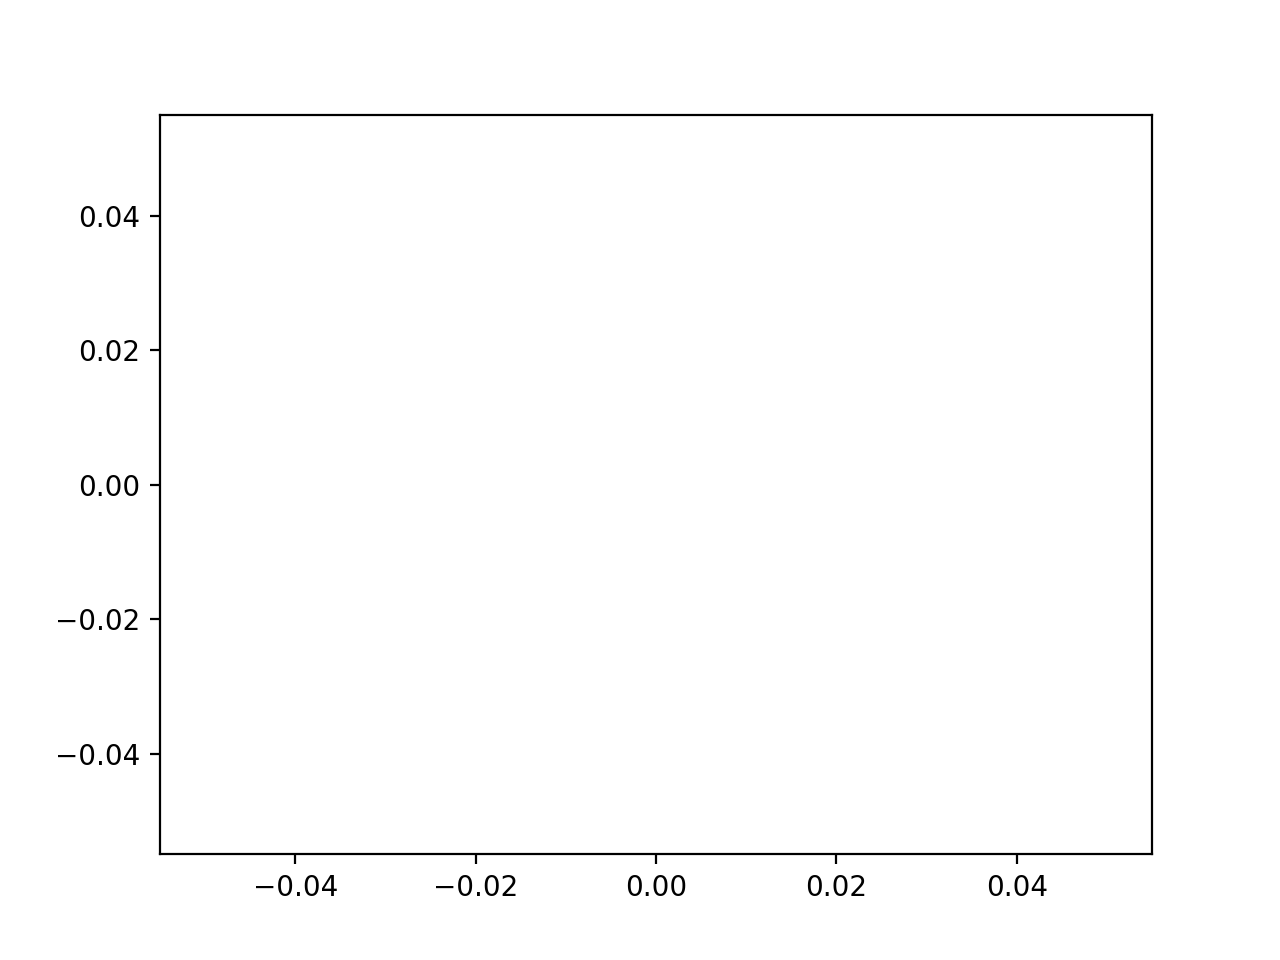

In [25]:
from matplotlib import pyplot as plt
a = hist[::1]
plt.plot(range(len(a)), a)
plt.show()

In [26]:
def test_rollout(t_max, env, close=True):
    import sys
    obs = agent.preprocess(env.reset())
    reward = 0
    for i in range(t_max):
        # print(agent.get_policy(obs))
        # act = agent.get_action(obs, greedy=True)[0]
        act = agent.get_action(obs, mode='greedy')[0][0]
        obs, r, dn, info = env.step(agent.action_wrapper(act))
        env.render()
        print(act, file=sys.stderr)
        time.sleep(0.05)
        obs = agent.preprocess(obs)
        reward += r
        if dn:
            break

    print("Total reward: {}".format(reward), file=sys.stderr)
    if close: env.close()

In [ ]:
if action == 'test':
    test_rollout(10000, env, close=True)

In [ ]:
# agent.train(4, t_max=500, min_buf_size=10)

In [ ]:
# %lprun -f agent.train agent.train(1, t_max=500, buf_size=2000, min_buf_size=10)